Homework 4 Part 2

In [0]:
import numpy as np
import pandas as pd 
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import cv2

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"willywu","key":"dfad6221ebc97ed6ba2322f41aaf760c"}'}

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [0]:
!pip install Pillow==4.1.1
!pip install fastai=0.7.0
!pip install torchtext==0.2.3
!pip install blosc 

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 96% 261M/271M [00:01<00:00, 144MB/s]
100% 271M/271M [00:01<00:00, 152MB/s]
 98% 531M/544M [00:02<00:00, 214MB/s]
100% 544M/544M [00:02<00:00, 203MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 42.9MB/s]


In [0]:
!unzip train.zip

In [123]:
!ls

 drive		    kaggle.json   sample_data		  test	     train
'kaggle (1).json'   model.h5	  sample_submission.csv   test.zip   train.zip


In [0]:
filenames = os.listdir("/content/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

catdog = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [192]:
train, test = train_test_split(catdog, test_size= 0.2, random_state=1)
print(train)
print(test)

            filename  category
6655    dog.7721.jpg         1
6085     dog.933.jpg         1
21848  dog.12285.jpg         1
5106    dog.4850.jpg         1
21856   cat.4997.jpg         0
...              ...       ...
10955   dog.9181.jpg         1
17289   dog.1214.jpg         1
5192    dog.7438.jpg         1
12172   cat.6003.jpg         0
235    dog.10374.jpg         1

[20000 rows x 2 columns]
           filename  category
21492  cat.3312.jpg         0
9488   dog.4630.jpg         1
16933   cat.503.jpg         0
12604  dog.3911.jpg         1
8222   cat.8832.jpg         0
...             ...       ...
11139  dog.3309.jpg         1
19053  dog.7769.jpg         1
7037   dog.1121.jpg         1
17119  dog.2241.jpg         1
20477  cat.1185.jpg         0

[5000 rows x 2 columns]


In [193]:
train["category"] = train["category"].replace({0: 'cat', 1: 'dog'}) 
test["category"] = test["category"].replace({0: 'cat', 1: 'dog'}) 
print(train)

            filename category
6655    dog.7721.jpg      dog
6085     dog.933.jpg      dog
21848  dog.12285.jpg      dog
5106    dog.4850.jpg      dog
21856   cat.4997.jpg      cat
...              ...      ...
10955   dog.9181.jpg      dog
17289   dog.1214.jpg      dog
5192    dog.7438.jpg      dog
12172   cat.6003.jpg      cat
235    dog.10374.jpg      dog

[20000 rows x 2 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
width = 256
height= 256
channels=3
batch_size = 32
size_train = 20000
size_test = 5000

In [217]:
train_datagen = ImageDataGenerator(  
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

train_gen = train_datagen.flow_from_dataframe(
    train, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=(width,height),
    class_mode='categorical',
    batch_size=batch_size
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(
    test, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=(width,height),
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [218]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, channels)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(2, 2))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(2, 2))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(2, 2))

model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(2, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model1.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_109 (Bat (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_110 (Bat (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 60, 60, 128)     

In [220]:
epochs=50
history = model1.fit_generator(
    train_gen, 
    epochs=epochs,
    validation_data=test_gen,
    validation_steps=size_test//batch_size,
    steps_per_epoch=size_train//batch_size,
)

Epoch 1/50
625/625 [==============================] - 318s 508ms/step - loss: 0.5763 - acc: 0.6975 - val_loss: 0.5287 - val_acc: 0.7318
Epoch 2/50
625/625 [==============================] - 314s 503ms/step - loss: 0.5171 - acc: 0.7437 - val_loss: 0.5363 - val_acc: 0.7338
Epoch 3/50
625/625 [==============================] - 315s 504ms/step - loss: 0.4836 - acc: 0.7678 - val_loss: 0.4719 - val_acc: 0.7715
Epoch 4/50
625/625 [==============================] - 316s 505ms/step - loss: 0.4518 - acc: 0.7893 - val_loss: 0.4066 - val_acc: 0.8193
Epoch 5/50
625/625 [==============================] - 315s 505ms/step - loss: 0.4264 - acc: 0.8051 - val_loss: 0.7722 - val_acc: 0.7122
Epoch 6/50
625/625 [==============================] - 310s 495ms/step - loss: 0.3949 - acc: 0.8260 - val_loss: 0.4152 - val_acc: 0.8139
Epoch 7/50
625/625 [==============================] - 308s 493ms/step - loss: 0.3745 - acc: 0.8353 - val_loss: 0.3762 - val_acc: 0.8329
Epoch 8/50
625/625 [============================

In [0]:
model1.save_weights("model.h5")

In [0]:
!ls

drive	     sample_data	    test.zip  train.zip
kaggle.json  sample_submission.csv  train


In [0]:
!unzip test.zip
!ls

In [224]:
test_data = os.listdir('/content/test')
test_df = pd.DataFrame({
    'id': test_data
})
nTest = test_df.shape[0]

test_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_gen = train_datagen.flow_from_dataframe(
    test_df,  
    '/content/test',
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=(height, width),
    batch_size=batch_size,
)

predict = model1.predict_generator(test_gen, steps= np.round(nTest / batch_size))

Found 12500 validated image filenames.


In [225]:
predict

array([[1.07061476e-01, 8.95302176e-01],
       [9.74257112e-01, 2.66921818e-02],
       [9.99999762e-01, 2.38418579e-07],
       ...,
       [9.99975204e-01, 2.47061253e-05],
       [9.99316335e-01, 7.16328621e-04],
       [9.90611315e-01, 9.98291373e-03]], dtype=float32)

In [226]:
predict1 = np.argmax(predict, axis=-1)
predict1.shape[0]

12500

In [0]:
test_df['label'] = predict1
test_df['image'] = test_df['id']
test_df['id'] = test_df.index + 1
submission = test_df[['id', 'label']]
submission.to_csv('submission2.csv', index=False)

In [230]:
submission

,id,label
0,1,1
1,2,0
2,3,0
3,4,0
4,5,1
...,...,...
12495,12496,0
12496,12497,1
12497,12498,0
12498,12499,0


In [205]:
!ls

 drive		    model.h5		    submission.csv   train
'kaggle (1).json'   sample_data		    test	     train.zip
 kaggle.json	    sample_submission.csv   test.zip


In [0]:
files.download("submission2.csv")

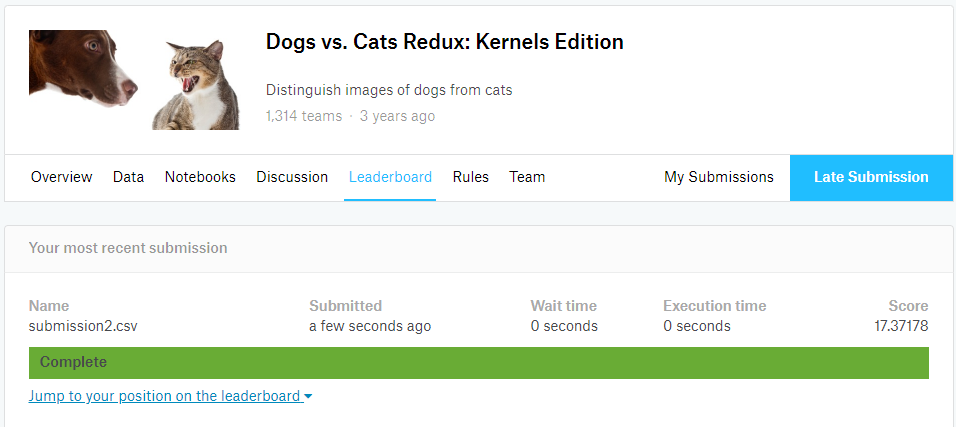